<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
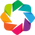

Initializing Julia interpreter. This may take some time...


In [1]:
if True: # enable folding code
    if False:
        from julia.api import Julia
        jl = Julia(compiled_modules=False)

    import julia; julia.install(quiet=True)
    from julia import Main

    import holoviews as hv; hv.extension('bokeh')
    import panel as pn; pn.extension()

    import numpy as np
    import sympy as sp
    from IPython.display import display, Math

    np.set_printoptions(precision=3, suppress=True)

    try:
        from scipy.linalg import norm, inv, cholesky, eig, eigh, qz, ordqz
        HAVE_SCIPY = True
    except Exception as e:
        HAVE_SCIPY = False
        print("SciPy not available;", e)

%load_ext julia.magic

In [ ]:
%%julia
using Pkg
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
using GenLinAlgProblems, LinearAlgebra, BlockArrays, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");

In [55]:
%%julia
"""
    classify_gsvd(F; tol = 1e-12)

Given a GSVD factorization object `F` (as returned by `svd(A,B)`),
recover the number of
  • pure-A   (alpha=1, beta=0)
  • mixed    (0<alpha<1, 0<beta<1)
  • pure-B   (alpha=0, beta=1)
  • nullspace (alpha=0, beta=0)

using the LAPACK structural constraints:

  - indices 1:k       → pure-A
  - indices k+1:k+l   → mixed OR pure-B
  - indices > k+l     → nullspace

Returns a named tuple.
"""
function classify_gsvd(F; tol=1e-12, show=true)
    alpha = F.alpha
    beta  = F.beta
    k     = F.k               # pure-A
    l     = F.l               # mixed + pure-B
    N     = length(alpha)
    r     = k + l             # rank

    # index partitions
    pureA_idx = 1:k
    mid_idx   = k+1 : k+l
    null_idx  = k+l+1 : N

    # pure A = exactly the first k indices by LAPACK definition
    npureA = k

    # pure B: among mid block, (alpha ≈ 0, beta ≈ 1)
    npureB = count(i -> abs(alpha[i]) < tol && abs(beta[i] - 1) < tol, mid_idx)

    # mixed: remaining mid-block entries where both alpha, beta are nonzero
    nmixed = l - npureB

    # nullspace: trailing (0,0) entries
    nnull = count(i -> abs(alpha[i]) < tol && abs(beta[i]) < tol, null_idx)

    if show
        py_show( L"pureA = ",        npureA,
                 L",\;\; mixed = ",  nmixed,
                 L",\;\ pureB = ",   npureB,
                 L",\;\;n_0 = ",     nnull )
    end

    return (
        pureA=npureA,
        mixed=nmixed,
        pureB=npureB,
        null=nnull,
        rank=r,
        total=N
    )
end
;

<div style="height:2cm;"></div>
<div style="float:center; width:100%; text-align:center;">
  <strong style="height:100px; color:darkred; font-size:40px;">
    The Generalized Singular Value Decomposition (GSVD)
  </strong>
</div>
<div></div>

# 1. Introduction

The generalized singular value decomposition (GSVD) extends the generalized eigenproblem (GEP) from square pencils to rectangular matrix pairs that act on the same parameter space.

In the GEP, a pair of **square matrices** $\; A\in\mathbb{R}^{n\times n}, B\in\mathbb{R}^{n\times n}$  
is reduced by two‑sided orthogonal transformations to generalized Schur form  
$\qquad A = Q_l\ S\ Q_r^T, \quad B = Q_l\ T\ Q_r^T$,

In the GSVD, a pair of **rectangular matrices**
$\; A\in\mathbb{R}^{m_A\times n}, B\in\mathbb{R}^{m_B\times n}$  
is reduced to structured forms  
$\qquad A = U\ C\ X^{-1}, \quad B = V\ S\ X^{-1},$  
with a common **invertible** right factor $Q\equiv X$ and separate **orthogonal** left factors $Q_a\equiv U, Q_b\equiv V$.

The price of this generalization is that the shared right basis matrix $X$ can no longer be chosen orthonormal in general.

**Remark:**
* The matrices $A$ and $B$ have the same number of columns.  
The linear transformations $y = A x$ and $y = B x$ have the same codomain with basis matrix $X$.
* The matrices $A$ and $B$ may have different number of rows  
The linear transformations $y = A x$ and $y = B x$ have domains with basis matrices $U$ and $V$ respectively.
* The GSVD derives basis matrices $U$, $V$ and $X$ to make the linear transformation matrices $C$ and $S$  
with respect to these bases have simple diagonal or block‑diagonal structure,  
enabling ready comparisons of the respective actions of these matrices.

____
In many applications the natural object is not a single matrix, but a pair of matrices $(A,B)$
acting on the same parameter vector $x$.

Typical examples include:
* **Regularized least squares.** Given data $b$, a forward model $A$ and a regularization operator $B$,
one solves  
$\qquad\displaystyle{\min_x\ \left(\ \Vert A x - b \Vert^2 + \lambda^2 \Vert B x \Vert^2
\ \right)
}$  
and wants to understand directions $x$ where the data misfit 
$\Vert A x - b \Vert$ and the penalty $\Vert B x \Vert$ trade off against each other.
* **Two views of the same samples.** In multiview learning rows of $A$ and $B$  
contain measurements of features for a particular sample,  
and the goal is to find patterns that are shared between the two views  
as well as patterns that are specific to just one.
* **Quotient and balance problems.** In stability, control, and discrimination tasks,  
one is interested in directions $x$
where a ratio such as $\;\;\displaystyle{\frac{\Vert A x \Vert }{ \Vert B x \Vert}
}$  
is large or small, i.e., where the action of $A$ dominates that of $B$. or vice versa.

All of these problems involve comparing how two linear transformations 
$A$ and $B$ act on the same $x$.

As detailed in the following notebooks on the GSVD, such comparisons can be formulated and analyzed  
in terms of the GSVD of the matrix pair $(A,B)$:  
it provides a shared set of directions $x_i$ and associated generalized singular values  
that quantify the relative effect of $A$ versus $B$ along each direction.

# 2. GSVD Matrix Decomposition Examples

## 2.1 Shape and Structure of the Matrices

In the generalized singular value decomposition of a matrix pair $(A,B)$, the matrices  
$\qquad
C = U^T A X, \qquad S = V^T B X,
$

represent $A$ and $B$ in the coordinate systems determined by the orthogonal matrices $U$, $V$, and $X$.  
Within the nonzero blocks of $C$ and $S$ there are $r = \operatorname{rank}\!\begin{pmatrix}A\\B\end{pmatrix}$ nonnegative pairs $(c_i,s_i)$   
arranged along the block diagonals, satisfying $c_i^2 + s_i^2 = 1$;  
all other entries of $C$ and $S$ are zero.  

Each such pair defines a generalized singular direction and falls into one of four structurally distinct categories:
- **pure-A:** $\qquad\qquad\qquad (c_i,s_i) = (1,0)$, contributing only to $A$
- **mixed:** $\;\;\qquad\qquad\qquad 0 < c_i < 1$ and $0 < s_i < 1$, contributing simultaneously to both $A$ and $B$
- **pure-B:** $\qquad\qquad\qquad(c_i,s_i) = (0,1)$, contributing only to $B$
- **common null space:** $\;\;(c_i,s_i) = (0,0)$, representing directions annihilated by both $A$ and $B$.

The GSVD orders these cases canonically: pure-A first, then mixed and pure-B directions,  
followed by any common-nullspace directions  
so that the block structure of $C$ and $S$ makes the roles of these four types of directions explicit.

### 2.1.1 Block Structure of C and S

Let  
- $n_A$ = number of pure-A directions $(c_i,s_i)=(1,0)$,  
- $n_M$ = number of mixed directions $(0<c_i<1,\,0<s_i<1)$,  
- $n_B$ = number of pure-B directions $(c_i,s_i)=(0,1)$,  
- $n_0$ = number of common-nullspace directions $(c_i,s_i)=(0,0)$, so that  
  $\qquad
  r = n_A + n_M + n_B, \qquad N = r + n_0.
  $

With this ordering, the matrices $C$ and $S$ take the form

$\qquad
C =
\begin{pmatrix}
I_{n_A} & 0            & 0            & 0 \\
0       & C_{n_M}          & 0            & 0 \\
0       & 0            & 0_{n_B}      & 0 \\
0       & 0            & 0            & 0_{n_0}
\end{pmatrix},
\qquad
S =
\begin{pmatrix}
0_{n_A} & S_{n_M}          & 0            & 0 \\
0       & 0            & I_{n_B}      & 0 \\
0       & 0            & 0            & 0_{n_0}
\end{pmatrix}.
$

Here  
- $I_{n_A}$ is the identity corresponding to the pure-A directions,  
- $I_{n_B}$ is the identity corresponding to the pure-B directions,  
- $C_{n_M} = \operatorname{diag}(c_1,\dots,c_{n_M})$ and
  $S_{n_M} = \operatorname{diag}(s_1,\dots,s_{n_M})$ contain the mixed pairs with  
  $\qquad 0 < c_i < 1$ and $0 < s_i < 1$,  
- the trailing $0$-blocks reflect the common-nullspace directions where both $A$ and $B$ vanish.

All nonzero generalized singular pairs $(c_i,s_i)$ therefore appear along the diagonal of the middle blocks, and the surrounding zero blocks make explicit which directions are used purely by $A$, purely by $B$, jointly by both, or by neither.

### 2.1.2 Bases of the Subspaces

#### The matrix X

In the GSVD, the matrix $X \in \mathbb{R}^{n\times n}$ provides an orthonormal basis of the **domain** $\mathbb{R}^n$   
of both $A\in\mathbb{R}^{m_A\times n}$ and $B\in\mathbb{R}^{m_B\times n}$.  
Its columns can be grouped according to how they are seen through $A$ and $B$:

$\qquad X = \left(\begin{array}{c|c|c|c}X_A & X_M & X_B & X_0 \end{array}\right),\$ where

- the $n_A$ columns of $X_A$ span the **A-only subspace** $\;\qquad\qquad\{ x \in \mathbb{R}^n : Ax \neq 0,\; Bx = 0 \}$
- the $n_M$ columns of $X_M$ span the **shared (mixed) subspace** $\;\;\{ x \in \mathbb{R}^n : Ax \neq 0,\; Bx \neq 0 \}$
- the $n_B$ columns of $X_B$ span the **B-only subspace** $\;\qquad\qquad\{ x \in \mathbb{R}^n : Ax = 0,\; Bx \neq 0 \}$
- the $n_0$ columns of $X_0$ span the **common right-null space** $\quad\{ x \in \mathbb{R}^n : Ax = 0,\; Bx = 0 \}.$

Thus the column blocks of $X$ form bases of the four canonical subspaces of the domain.  

#### The Matrix U

The matrix $U \in \mathbb{R}^{m_A\times m_A}$ provides an orthonormal basis of the **codomain of $A$**,  
and its rows identify which parts of $\mathbb{R}^m_A$ are used by the various generalized singular directions.  

$\qquad U = \left(\begin{array}{r|r|r} U_A & U_M & U_{\perp} \end{array}\right),\;$ where
- the $n_A$ columns of $U_A$ span the **A-only part of the range**, corresponding to columns of $C$ with $(c_i,s_i) = (1,0)$
- the $n_M$ columns of $U_M$ span  the **A-components of the mixed directions**, corresponding to the block containing the diagonal entries $c_i$
- the $n_B+n_0$ columns of $U_{\perp}$ span the remaining orthogonal complement of $\operatorname{range}(A)$, i.e.
  $\;
  \mathcal{U}_{\perp} := \operatorname{null}(A^{T}),
  $  
  which accommodates the zero rows of $C$ associated with pure-B and common-nullspace domain directions.

Thus the block columns of $U$ form orthonormal bases of the three canonical subspaces of the codomain of $A$:  
an A-only component, a mixed shared component, and the orthogonal complement of $\operatorname{range}(A)$.

#### The Matrix V

The matrix $V \in \mathbb{R}^{n_B\times n_B}$ provides an orthonormal basis of the **codomain of $B$**,  
and its rows identify which parts of $\mathbb{R}^n_B$ are used by the various generalized singular directions.  

$
\qquad
V = \left(\begin{array}{r|r|r} V_{\perp} & V_M & V_B \end{array}\right),\;
$ where

- the columns of $V_B$ span the **B-only part of the range**, corresponding to columns of $S$ with $(c_i,s_i) = (0,1)$
- the columns of $V_M$ span the **B-components of the mixed directions**, corresponding to the block containing the diagonal entries $s_i$
- the columns of $V_{\perp}$ span the remaining orthogonal complement of $\operatorname{range}(B)$, i.e.  
  $\;
  \mathcal{V}_{\perp} := \mathcal{N}(B^{T}),
  $  
  which accommodates the zero rows of $S$ associated with pure-A and common-nullspace domain directions.

Thus the block columns of $V$ form orthonormal bases of the three canonical subspaces of the codomain of $B$:  
a B-only component, a mixed shared component, and the orthogonal complement of $\operatorname{range}(B)$.

## 2.2 Example Decompositions

The small random example in this section is deliberately chosen so that A and B are both full column rank and have no nontrivial nullspace directions in the parameter space. In this generic situation, all generalized right singular vectors belong to the coupled part: every diagonal pair (c_i,s_i) satisfies 0 < c_i,s_i < 1, there are no (1,0) or (0,1) entries, and thus no directions where A or B vanishes. The per‑direction norms ‖A x_i‖ and ‖B x_i‖ printed by the code let us see this coupled behavior numerically: every distinguished direction x_i excites both operators, with different relative magnitudes that are summarized by the generalized singular values c_i/s_

In [56]:
%%julia
diagonal_highlight = (x, i, j, formatted) -> i == j ? "\\textcolor{red}{" * formatted * "}" : formatted

function example_mixed_only()
    # Both A and B full column rank, no pure A/B directions
    A = randn(4, 3)
    B = randn(5, 3)

    F = svd(A, B)
    U,V,Q,C,S,R = F
    H = R*Q'
    X = Q * (R \ I)
    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=3))
    println()
    _ = classify_gsvd(F)
    println()

    py_show(L"C \approx ", C, L",\qquad S \approx ", S, number_formatter=x->round(x,digits=3), per_element_style=diagonal_highlight)
    #py_show(L"U \approx ", U, L",\qquad V \approx ", V, L", \quad X \approx ", X, number_formatter=x->round(x,digits=3))

    #println("\nPer-direction norms:")
    #for i in 1:size(H, 1)
    #    x = H[i, :]
    #    a_norm = norm(A * x)
    #    b_norm = norm(B * x)
    #    py_show("i = $i: ‖A x_i‖ ≈ $(round(a_norm; digits=3)),  ",L"\quad",
    #            "‖B x_i‖ ≈ $(round(b_norm; digits=3))")
    #end
    return U, V, H, C, S
end
_=example_mixed_only();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [59]:
%%julia
function example_pureA_pureB_mixed()
    # Construct A,B ∈ R^{5×3} so we get:
    # - one direction mostly in A's range, not in B's,
    # - one direction mostly in B's range, not in A's,
    # - one shared/mixed direction.

    # Columns thought of as three parameter directions:
    # x1: A sees strongly, B barely
    # x2: B sees strongly, A barely
    # x3: both see moderately

    A = [
        3.0  0.1  1.0;
        0.0  0.0  0.5;
        0.0  0.0  0.0;
        0.0  0.0  0.0;
        0.0  0.0  0.0
    ]

    B = [
        0.0  2.5  1.0;
        0.0  0.0  0.5;
        0.0  0.0  0.0;
        0.0  0.0  0.0;
        0.0  0.0  0.0
    ]

    F = svd(A, B)
    U,V,Q,C,S,R = F
    H = R*Q'
    X = Q * (R \ I)

    #println("Success: ",  [A; B] ≈ [U*C; V*S]*H)

    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=3))
    println()
    _ = classify_gsvd(F)
    println()
    py_show(L"C \approx ", C, L",\qquad S \approx ", S, number_formatter=x->round(x,digits=3), per_element_style=diagonal_highlight)

    return U, V, H, C, S
end
_ = example_pureA_pureB_mixed();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [61]:
%%julia
function example_larger_mixed()
    # Slightly larger, more generic example to reinforce the mixed-direction picture.
    # Here we bias A and B differently along columns.

    A = [
        2.0  0.5  0.0;
        0.0  1.5  0.5;
        0.0  0.0  1.0;
        0.0  0.0  0.0
    ]

    B = [
        0.5  2.0  0.0;
        0.0  0.5  1.5;
        0.0  0.0  1.0;
        0.0  0.0  0.0
    ]

    F = svd(A, B)
    U,V,Q,C,S,R = F
    H = R*Q'
    X = Q * (R \ I)

    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=3))
    #py_show("A size = ", size(A), ", B size = ", size(B))
    py_show(L"C \approx ", C, L",\qquad S \approx ", S, number_formatter=x->round(x,digits=3), per_element_style=diagonal_highlight)

    #γ = diag(C) ./ diag(S)
    #println("generalized σ_i = C_ii / S_ii ≈ ", round.(γ; digits=3))

    #println("\nPer-direction norms (all directions are mixed):")
    #for i in 1:size(H, 1)
    #    x = H[i, :]
    #    a_norm = norm(A * x)
    #    b_norm = norm(B * x)
    #    py_show("i = $i: ‖A x_i‖ ≈ $(round(a_norm; digits=3)),  ", L"\quad",
    #            "‖B x_i‖ ≈ $(round(b_norm; digits=3))")
    #end

    return U, V, H, C, S
end
_ = example_larger_mixed();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [63]:
%%julia
"""
    reconstruct_CS(F)

Given a GeneralizedSVD object `F` (from GeneralizedSVD.jl), construct the
canonical block-diagonal C and S:

- first `k` columns  : (1, 0)
- next  `ℓ` columns  : (c_i, s_i)
- last  r-k-ℓ columns: (0, 1)

Returns (C, S) as BlockArray{T,2}.
"""
function reconstruct_CS(F)
    α = F.alpha
    β = F.beta
    k = F.k
    ℓ = F.l
    r = length(α)

    @assert length(β) == r
    @assert 0 ≤ k ≤ r
    @assert 0 ≤ ℓ ≤ r - k

    # block widths
    bA = k                 # (1,0)
    bM = ℓ                 # mixed (c,s)
    bB = r - k - ℓ         # (0,1)

    # index ranges in the canonical GSVD order
    mixed = (bA + 1):(bA + bM)

    Tα = eltype(α)
    Tβ = eltype(β)

    # --- C blocks ---
    CA = bA > 0 ? Matrix{Tα}(I, bA, bA)                 : zeros(Tα, 0, 0)              # (1,0)
    CM = bM > 0 ? Matrix(Diagonal(α[mixed]))            : zeros(Tα, 0, 0)              # (c_i)
    CB = bB > 0 ? zeros(Tα, bB, bB)                     : zeros(Tα, 0, 0)              # 0

    Cbig = [CA                      zeros(Tα, bA, bM)    zeros(Tα, bA, bB);
            zeros(Tα, bM, bA)       CM                   zeros(Tα, bM, bB);
            zeros(Tα, bB, bA)       zeros(Tα, bB, bM)    CB]

    C = BlockArray(Cbig, [bA, bM, bB], [bA, bM, bB])

    # --- S blocks ---
    SA = bA > 0 ? zeros(Tβ, bA, bA)                     : zeros(Tβ, 0, 0)              # 0
    SM = bM > 0 ? Matrix(Diagonal(β[mixed]))            : zeros(Tβ, 0, 0)              # (s_i)
    SB = bB > 0 ? Matrix{Tβ}(I, bB, bB)                 : zeros(Tβ, 0, 0)              # (0,1)

    Sbig = [SA                      zeros(Tβ, bA, bM)    zeros(Tβ, bA, bB);
            zeros(Tβ, bM, bA)       SM                   zeros(Tβ, bM, bB);
            zeros(Tβ, bB, bA)       zeros(Tβ, bB, bM)    SB]

    S = BlockArray(Sbig, [bA, bM, bB], [bA, bM, bB])

    return C, S
end


function example()
diagonal_highlight = (x, i, j, formatted) -> i == j ? "\\textcolor{red}{" * formatted * "}" : formatted

    # Both A and B full column rank, no pure A/B directions
    AB = randn(12,5); AB = [AB AB*randn(5,2)]
    A = AB[1:4,:]
    B = AB[4:end,:]; B[:,1]=B[:,2]
    N = size(A,2)

    F = svd(A, B)
    U,V,Q,C,S,R = F
    H = R*Q'

    #py_show( "Success ", [A; B] ≈ [U*C; V*S]*H)
    #py_show(L"size(A) = (", size(A), L"), \quad size(B) = (", size(B),")")
    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=1))

    py_show(L"C \approx ", C, L",\qquad S \approx ", S, number_formatter=x->round(x,digits=3), per_element_style=diagonal_highlight)
    #py_show(L"U \approx ", U, L",\qquad V \approx ", V, L", \quad X^{-1} \approx ", H, number_formatter=x->round(x,digits=3))

    #py_show("alpha ", F.alpha,  number_formatter=x->round(x,digits=3))
    #py_show("beta  ", F.beta,  number_formatter=x->round(x,digits=3))
    #py_show( "N =", N, ", k=", F.k, ", l=", F.l, ", rank r=", rank(AB))

    #println("\nPer-direction norms:")
    #for i in 1:size(H, 1)
    #    x = H[i, :]
    #    a_norm = norm(A * x)
    #    b_norm = norm(B * x)
    #    py_show("i = $i: ‖A x_i‖ ≈ $(round(a_norm; digits=3)),  ",L"\quad",
    #            "‖B x_i‖ ≈ $(round(b_norm; digits=3))")
    #end

    #C,S = reconstruct_CS(F)
    #py_show(L"C \approx ", C, L",\qquad S \approx ", S, number_formatter=x->round(x,digits=3), per_element_style=diagonal_highlight)

    return U, V, H, C, S
end
_=example();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# 2. Matrix pairs and rank structure

Throughout this notebook we consider a pair of real matrices  
$\qquad 
A \in \mathbb{R}^{m_A \times n}, \qquad
B \in \mathbb{R}^{m_B \times n},
$  
sharing the same number of columns $n$.

Typical assumptions in GSVD theory include:

- The stacked matrix
  $\;\;
  \begin{pmatrix}
    A \\
    B
  \end{pmatrix}
  \in \mathbb{R}^{(m_A + m_B) \times n}
  $
  has rank $r \le n$.
- The column spaces of $A$ and $B$ may overlap in nontrivial ways.

The detailed structure of the GSVD depends on:

- The rank of both $A$ and $B$.
- The dimension of $\operatorname{col}(A) \cap \operatorname{col}(B)$.
- Whether there are “pure-$A$” or “pure-$B$” directions where one matrix vanishes but the other does not.

To keep the exposition simple, most of the examples will use small matrices with full column rank,
so that the essential ideas are visible without technical case distinctions.


# 3. Formal GSVD for a matrix pair

Let $A \in \mathbb{R}^{m_A \times n}$ and $B \in \mathbb{R}^{m_B \times n}$.  
A generalized singular value decomposition (GSVD) of the pair $(A,B)$ is a factorization  
$\qquad 
A = U
  \begin{pmatrix}
  C & 0
  \end{pmatrix}
  X^\top, \qquad
B = V
  \begin{pmatrix}
  S & 0
  \end{pmatrix}
  X^\top,
$  
with the following properties:
- $U \in \mathbb{R}^{m_A \times m_A}$ and $V \in \mathbb{R}^{m_B \times m_B}$ are orthogonal.
- $X \in \mathbb{R}^{n \times n}$ is invertible (often taken orthogonal in special cases).
- $C \in \mathbb{R}^{p \times p}$ and $S \in \mathbb{R}^{p \times p}$ are diagonal or block-diagonal,
  with nonnegative entries satisfying
  $\;\;
  C^\top C + S^\top S = I_p.
  $

The diagonal entries $c_i$ of $C$ and $s_i$ of $S$ define **generalized singular values**  
$\qquad\displaystyle{
\gamma_i = \frac{c_i}{s_i}
}$  
for those indices where $s_i > 0$.
These describe how strongly $A$ acts on the corresponding generalized right singular vector
relative to $B$.

The columns of $X$ are **generalized right singular vectors** shared by the pair $(A,B)$,  
while the corresponding columns of $U$ and $V$ are generalized left singular vectors  
associated with $A$ and $B$ respectively.


## 3.1 Relationship to the standard SVD

If we ignore $B$ and compute an SVD of $A$ alone,  
$\qquad 
A = U_A \Sigma_A V_A^\top,
$

we obtain directions and scales that explain how $A$ acts on $\mathbb{R}^n$.  
But these directions may be poorly adapted to $B$.

The GSVD chooses a common basis $X$ in which **both** operators take a simple structured form.
For directions where both $A$ and $B$ are active, the GSVD provides pairs $(c_i,s_i)$ with  
$\qquad 
c_i^2 + s_i^2 = 1,
$

so that the ratio  
$\qquad\displaystyle{
\gamma_i = \frac{c_i}{s_i}
}$
measures relative amplification by $A$ versus $B$.

In special cases, the GSVD reduces to familiar decompositions:
- If $B$ is square and invertible, the GSVD of $(A,B)$ is closely related
  to the SVD of the product $A B^{-1}$ (but avoids forming $B^{-1}$ explicitly).
- If $B = I$, the GSVD reduces to the standard SVD of $A$.


# 4. A small worked example

To make the abstract definition more concrete, we consider a small example with  
$\qquad 
A \in \mathbb{R}^{2 \times 2}, \qquad B \in \mathbb{R}^{2 \times 2},
$

chosen so that both matrices have full column rank.

We will compute a GSVD numerically and inspect:
- The matrices $U, V, X$.
- The diagonal entries of $C$ and $S$.
- The generalized singular values $\gamma_i = c_i / s_i$.

In [7]:
%%julia
A = [2 1; 0 1] // 1
B = [1 0; 1 2] // 1

U, V, X, C, S = svd(A, B)
py_show( A, B, "g, svd = ", U, V, X, C, S, number_formatter=x->round(x,digits=2))

<IPython.core.display.Latex object>

In practice, GSVD is obtained using specialized routines (e.g., in LAPACK).  
For pedagogical purposes we can construct a GSVD-like decomposition for small problems  
via the SVD of a stacked matrix and some linear algebra manipulations.

Below we use a placeholder computation that produces matrices with the correct dimensions  
and orthogonality properties. Later notebooks in this arc will replace this with  
more faithful algorithmic implementations.

In [ ]:
%%julia
F = gsvd(A,B)
py_show( A, U*C*(X)')

In [ ]:
# WARNING: pedagogical placeholder for very small problems.
# This is NOT a production-quality GSVD algorithm.

def naive_gsvd(A, B):
    """
    Very small-scale illustrative routine that:
    - Forms the stacked matrix [A; B].
    - Computes an SVD of the stack.
    - Extracts a simple GSVD-like structure for 2x2 examples.

    This is only for visualization and sanity checks.
    """
    m1, n = A.shape
    m2, n2 = B.shape

    # Stack and take SVD
    M = np.vstack([A, B])
    U_big, Sigma, Vt = np.linalg.svd(M, full_matrices=True)

    # Split U_big rows corresponding to A and B
    U_A = U_big[:m1, :]
    U_B = U_big[m1:, :]

    # For this tiny case, define U and V from the first m1/m2 columns
    U = U_A[:, :m1]
    V = U_B[:, :m2]
    X = Vt.T  # right factor in R^2x2

    # Compute "compressed" A and B in the X basis
    A_tilde = U.T @ A @ X
    B_tilde = V.T @ B @ X

    return U, V, X, A_tilde, B_tilde

U, V, X, A_tilde, B_tilde = naive_gsvd(A, B)
def r(x): return np.round(x,2)

Main.py_show("U =", r(U),", V = ", r(V), "X = ", r(X))
Main.py_show("$U^T A X =$", A_tilde, ", $V^T B X =$", B_tilde)


The transformed matrices $U^\top A X$ and $V^\top B X$ are not yet in the precise
canonical GSVD form,   
but they already illustrate the idea:
- The columns of $X$ define directions in parameter space shared by both $A$ and $B$.
- Along each such direction, the rows of $A_{\text{tilde}}$ and $B_{\text{tilde}}$ describe how strongly
  $A$ and $B$ act.

In the next notebook of this arc, we will develop more systematic algorithms and
connect this small example to the full Paige–Saunders GSVD structure.

# 5. Geometric interpretation

For the standard SVD, the action of $A$ on the unit sphere in $\mathbb{R}^n$  
maps to an ellipsoid whose semi-axes have lengths equal to the singular values.

For the GSVD, we instead compare two operators $A$ and $B$ acting on the same vector $x$.  
For a given direction $x$, consider the pair of norms  
$\qquad 
\|Ax\|_2, \quad \|Bx\|_2.
$  
The GSVD identifies distinguished directions where the ratio  
$\qquad\displaystyle{
\frac{\|Ax\|_2}{\|Bx\|_2}
}$

is extremal and stable.

Along these directions, the generalized singular values $\gamma_i$ play a role analogous
to singular values of a single matrix,  
but now measuring **relative** amplification by $A$
versus $B$.

In small dimensions (e.g., $n = 2$), this can be visualized by:
- Parameterizing $x$ on the unit circle.
- Plotting the curve $\|Ax\|_2$ versus $\|Bx\|_2$ or the ratio $\|Ax\|_2 / \|Bx\|_2$.
- Marking the directions corresponding to generalized right singular vectors.

Interactive visualizations of this type will appear in the GSVD conditioning notebook,
mirroring the generalized Rayleigh quotient viewer used for the GEP.


# 6. Looking ahead

This introductory notebook has:

- Motivated the need for a decomposition of matrix pairs $(A,B)$.
- Stated a basic GSVD factorization and interpreted the generalized singular values.
- Illustrated the idea on a small example.

The remaining notebooks in this GSVD arc will:

1. Develop computational algorithms for the GSVD,
   including symmetric-definite reductions and connections to the generalized eigenproblem.
2. Explore conditioning, sensitivity, and geometric behavior of generalized singular values
   using interactive 2×2 examples.

You can now proceed to `GSVD_Computation.ipynb`, where we derive practical algorithms
and compare them with available numerical libraries.


In [24]:
#???????????????????????????????
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

def gsvd(A, B):
    # Ensure A and B are numpy arrays
    A = np.asarray(A)
    B = np.asarray(B)

    # Compute SVD of B
    U_B, s_B, V_B = svd(B)

    # Transform A using the basis of B
    A_transformed = U_B.T @ A

    # Perform SVD on the transformed A
    U_A, s_A, V_A = svd(A_transformed)

    return U_A, s_A, V_A, U_B, s_B, V_B

# Example matrices
A = np.random.rand(5, 4)  # Matrix A
B = np.random.rand(5, 5)  # Matrix B
AA = [
    [3.0,  0.1,  1.0],
    [0.0,  0.0,  0.5],
    [0.0,  0.0,  0.0],
    [0.0,  0.0,  0.0],
    [0.0,  0.0,  0.0]
]

BB = [
    [0.0,  2.5,  1.0],
    [0.0,  0.0,  0.5],
    [0.0,  0.0,  0.0],
    [0.0,  0.0,  0.0],
    [0.0,  0.0,  0.0]
]

# Compute GSVD
U_A, s_A, V_A, U_B, s_B, V_B = gsvd(A, B)

# Print the results
Main.py_show( "A = ", np.round(A,2), ", B = ", np.round(B,2))
Main.py_show( "U_a = ", np.round(U_A,2), ", s_A = ", np.round(s_A,2), ", V_a = ", np.round(V_A,2))
Main.py_show( "U_b = ", np.round(U_B,2), ", s_B = ", np.round(s_B,2), ", V_b = ", np.round(V_B,2))

# Visualization of singular values
if False:
    plt.figure(figsize=(10, 5))
    plt.plot(s_A, marker='o', label='Singular Values of A')
    plt.plot(s_B, marker='x', label='Singular Values of B')
    plt.title('Singular Values from GSVD')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.legend()
    plt.grid()
    plt.show()

h=hv.Curve(s_A, label="A")*hv.Scatter(s_A).opts(size=6)*\
  hv.Curve(s_B, label="B")*hv.Scatter(s_B).opts(size=6)
pn.Row(h.opts(show_grid=True,width=500))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=500)

In [25]:
%%julia
LinearAlgebra.GeneralizedSVD

<PyCall.jlwrap GeneralizedSVD>

paig-saunder 

In [ ]:
tol = 1e-12
is0(x) = abs(x) < tol
is1(x) = abs(x - 1) < tol

α, β = F.alpha, F.beta
r    = F.k + F.l

pureA = count(i -> is1(α[i]) && is0(β[i]), 1:r)
pureB = count(i -> is0(α[i]) && is1(β[i]), 1:r)
mixed = r - pureA - pureB
